In [1]:
import os 
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-05-10 23:26:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
storage.googleapis.com (storage.googleapis.com)을(를) 해석하는 중... 34.64.4.16, 34.64.4.112, 34.64.4.48, ...
접속 storage.googleapis.com (storage.googleapis.com)|34.64.4.16|:443... 접속됨.
HTTP 요청을 전송했습니다. 응답을 기다리는 중입니다... 200 OK
길이: 87910968 (84M) [application/x-hdf]
다음 위치에 저장: `/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

/tmp/inception_v3_w 100%[===================>]  83.84M  7.95MB/s    / 14s      

2021-05-10 23:27:11 (6.02 MB/s) - `/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5' 저장됨 [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weight_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
pretrained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

In [5]:
pretrained_model.load_weights(local_weight_file)

In [6]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [7]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
last_layer = pretrained_model.get_layer('mixed7')
print(f'last layer shape : {last_layer.output_shape}')
last_output = last_layer.output

last layer shape : (None, 7, 7, 768)


In [13]:
from tensorflow.keras.optimizers import RMSprop

In [18]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [19]:
model = Model(pretrained_model.input, x)

In [20]:
model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2021-05-10 23:36:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
storage.googleapis.com (storage.googleapis.com)을(를) 해석하는 중... 34.64.4.112, 34.64.4.80, 34.64.4.48, ...
접속 storage.googleapis.com (storage.googleapis.com)|34.64.4.112|:443... 접속됨.
HTTP 요청을 전송했습니다. 응답을 기다리는 중입니다... 200 OK
길이: 68606236 (65M) [application/zip]
다음 위치에 저장: `/tmp/cats_and_dogs_filtered.zip'

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  7.93MB/s    / 9.1s     

2021-05-10 23:36:52 (7.22 MB/s) - `/tmp/cats_and_dogs_filtered.zip' 저장됨 [68606236/68606236]



In [22]:
import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 55s - loss: 0.3559 - accuracy: 0.8710 - val_loss: 0.3076 - val_accuracy: 0.8880
Epoch 2/20
100/100 - 51s - loss: 0.2296 - accuracy: 0.9060 - val_loss: 0.1335 - val_accuracy: 0.9470
Epoch 3/20
100/100 - 52s - loss: 0.2147 - accuracy: 0.9195 - val_loss: 0.0966 - val_accuracy: 0.9640
Epoch 4/20
100/100 - 49s - loss: 0.2110 - accuracy: 0.9180 - val_loss: 0.0812 - val_accuracy: 0.9680
Epoch 5/20
100/100 - 54s - loss: 0.1920 - accuracy: 0.9265 - val_loss: 0.1332 - val_accuracy: 0.9570
Epoch 6/20
100/100 - 56s - loss: 0.1855 - accuracy: 0.9315 - val_loss: 0.2352 - val_accuracy: 0.9320
Epoch 7/20
100/100 - 54s - loss: 0.1893 - accuracy: 0.9320 - val_loss: 0.0925 - val_accuracy: 0.9660
Epoch 8/20
100/100 - 50s - loss: 0.1757 - accuracy: 0.9430 - val_loss: 0.2399 - val_accuracy: 0.9350
Epoch 9/20
100/100 - 52s - loss: 0.1664 - accuracy: 0.9500 - val_loss: 0.1007 - val_accuracy: 0.9660
Epoch 10/20
100/100 - 47s - loss: 0.1616 - accuracy: 0.9465 - val_loss: 0.1175 - val_accura

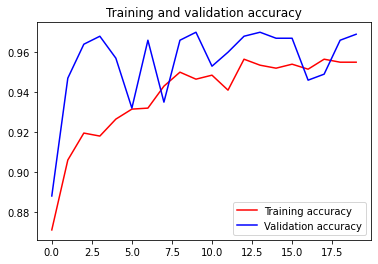

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()